In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Subset
import random
import numpy as np
import os
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import copy
import pickle

In [2]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [3]:
vgg11 = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11.classifier[6] = torch.nn.Linear(4096, 100)
vgg11.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
vgg11.load_state_dict(torch.load('models/vgg11_cifar100_baseline_5e.pt', weights_only=True, map_location=device))
vgg11.to(device)


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


100%|██████████| 507M/507M [00:05<00:00, 103MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [4]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 128
NUM_WORKERS = 4

g = torch.Generator()
g.manual_seed(42)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
full_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)
_, small_test_subset = random_split(full_test, [7500, 2500], generator=g)
train_subset, val_subset = random_split(full_train, [45000, 5000], generator=g)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform
full_test.transform = test_transform
small_test_subset.transform = test_transform

print("Training set size:", len(train_subset))
print("Validation set size:", len(val_subset))
print("Test Set Size:", len(full_test))
print("Small Test Size:", len(small_test_subset))

def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_subset, shuffle=True)
val_loader = get_loader(val_subset, shuffle=False)
test_loader = get_loader(full_test, shuffle=False)
small_test_loader = get_loader(small_test_subset, shuffle=False)

100%|██████████| 169M/169M [00:03<00:00, 47.1MB/s]


Training set size: 45000
Validation set size: 5000
Test Set Size: 10000
Small Test Size: 2500


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [6]:
base_acc = evaluate(vgg11, test_loader, device)
print(f"Base Acc: {base_acc:.2f}")
base_acc = evaluate(vgg11, small_test_loader, device)
print(f"Base Acc (small): {base_acc:.2f}")

Base Acc: 71.01
Base Acc (small): 70.64


In [7]:
def prune_layer_structured_L2(model, target_layer, amount):
    """
    Performs structured channel-wise pruning on a Conv2d layer.
    Prunes entire output channels with smallest L2-norms, and adjusts the next Conv2d layer.
    """
    # Convert layer name (like "features.3") to module reference
    modules = dict(model.named_modules())
    if target_layer not in modules or not isinstance(modules[target_layer], torch.nn.Conv2d):
        print(f"Skipping {target_layer} (not Conv2d)")
        return model

    conv = modules[target_layer]
    with torch.no_grad():
        # Compute L2 norm of each output channel (filter)
        weight = conv.weight.data
        out_channels = weight.shape[0]
        num_prune = int((amount/100) * out_channels)
        if num_prune == 0:
            return model

        norms = torch.norm(weight.view(out_channels, -1), p=2, dim=1)
        prune_idx = torch.argsort(norms)[:num_prune]
        keep_idx = torch.argsort(norms)[num_prune:]

        # Prune current layer (reduce output channels)
        conv.weight = torch.nn.Parameter(weight[keep_idx].clone())
        if conv.bias is not None:
            conv.bias = torch.nn.Parameter(conv.bias.data[keep_idx].clone())
        conv.out_channels = len(keep_idx)

        # Find the next Conv2d and prune corresponding input channels
        found = False
        prev_name = target_layer
        for name, module in modules.items():
            if found and isinstance(module, torch.nn.Conv2d):
                next_conv = module
                next_weight = next_conv.weight.data[:, keep_idx, :, :].clone()
                next_conv.weight = torch.nn.Parameter(next_weight)
                next_conv.in_channels = len(keep_idx)
                break
            if name == target_layer:
                found = True

    return model


In [8]:
conv_layers = [name for name, module in vgg11.named_modules() if isinstance(module, torch.nn.Conv2d)]

prune_amts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
sensitivity_dict = {}
for layer in conv_layers[:-1]:
    print(f"Layer {layer}")
    sensitivity_dict[(layer, 0)] = base_acc
    for perc in prune_amts:
        vgg11_copy = copy.deepcopy(vgg11)
        pruned_model = prune_layer_structured_L2(vgg11_copy, layer, perc)
        acc = evaluate(pruned_model, small_test_loader, device)
        print(f"{perc}% channel pruning: {acc:.2f}% Accuracy")
        sensitivity_dict[(layer, perc)] = acc

Layer features.0
5% channel pruning: 70.24% Accuracy
10% channel pruning: 70.48% Accuracy
15% channel pruning: 70.32% Accuracy
20% channel pruning: 69.88% Accuracy
25% channel pruning: 69.32% Accuracy
30% channel pruning: 67.52% Accuracy
35% channel pruning: 64.80% Accuracy
40% channel pruning: 64.72% Accuracy
45% channel pruning: 64.56% Accuracy
50% channel pruning: 60.60% Accuracy
55% channel pruning: 52.40% Accuracy
60% channel pruning: 51.88% Accuracy
Layer features.3
5% channel pruning: 70.68% Accuracy
10% channel pruning: 70.60% Accuracy
15% channel pruning: 70.68% Accuracy
20% channel pruning: 70.64% Accuracy
25% channel pruning: 69.92% Accuracy
30% channel pruning: 68.88% Accuracy
35% channel pruning: 68.16% Accuracy
40% channel pruning: 67.84% Accuracy
45% channel pruning: 67.32% Accuracy
50% channel pruning: 67.16% Accuracy
55% channel pruning: 65.72% Accuracy
60% channel pruning: 62.16% Accuracy
Layer features.6
5% channel pruning: 70.68% Accuracy
10% channel pruning: 70.72%

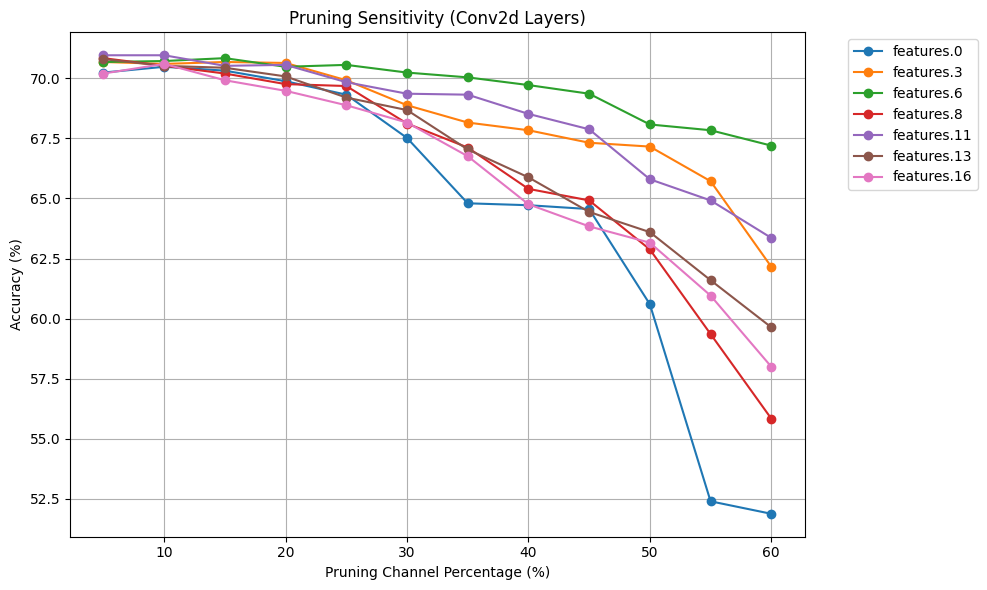

In [9]:
# --- Plot for Conv layers ---
plt.figure(figsize=(10, 6))
for layer in conv_layers[:-1]:
    accs = [sensitivity_dict.get((layer, p)) for p in prune_amts]
    plt.plot([p for p in prune_amts], accs, marker='o', label=layer)

plt.title("Pruning Sensitivity (Conv2d Layers)")
plt.xlabel("Pruning Channel Percentage (%)")
plt.ylabel("Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Save the dictionary to a file
with open('sensitivity_dict_structured.pkl', 'wb') as f:
    pickle.dump(sensitivity_dict, f)